In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import struct
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
%matplotlib inline

In [2]:
# src: https://www.kaggle.com/code/abdullahtursun/recognizing-digits-using-cnn-98-accuracy
def load_image_file(file_path):
    with open(file_path, "rb") as file:    
        file.read(16)    # Skip the header for images
        binary_data = file.read()
        numpy_data = np.frombuffer(binary_data, dtype=np.uint8)
        num_images = numpy_data.size // 784 
        data = numpy_data.reshape(num_images, 784)
        return data

def load_label_file(file_path):
    with open(file_path, "rb") as file:    
        file.read(16)    # Skip the header for images
        binary_data = file.read()
        data = np.frombuffer(binary_data, dtype=np.uint8)
        return data

In [3]:
def read_mnist_file(filename):
    with open(filename, "rb") as f:
        # Read the magic number and number of items
        magic, num_items = struct.unpack('>II', f.read(8))
        # Check if it's an image file (magic number 2051) or label file (magic number 2049)
        if magic == 2051:
            # Read the number of rows and columns
            rows, cols = struct.unpack('>II', f.read(8))
            # Read the image data
            data = np.fromfile(f, dtype=np.uint8).reshape(num_items, rows, cols)
        elif magic == 2049:
            # Read the label data
            data = np.fromfile(f, dtype=np.uint8)
        else:
            raise ValueError('Invalid magic number')
    return data

The MNIST (Modified National Institute of Standards and Technology) data consists of 60,000 training images and 10,000 test images. Each image is a crude 28 x 28 (784 pixels) handwritten digit from "0" to "9." Each pixel value is a grayscale integer between 0 and 255.

In [6]:
train_imgs = read_mnist_file("./data/mnist/train-images.idx3-ubyte")
test_imgs = read_mnist_file("./data/mnist/t10k-images.idx3-ubyte")
train_lbls = read_mnist_file("./data/mnist/train-labels.idx1-ubyte")
test_lbls = read_mnist_file("./data/mnist/t10k-labels.idx1-ubyte")

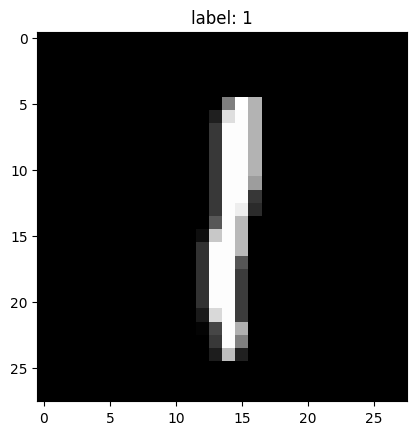

In [65]:
# ref: https://matplotlib.org/stable/tutorials/images.html
def display_img(imgs,lbls):
    idx = np.random.randint(0, len(lbls))
    img = imgs[idx]
    pixels = img.reshape(28, 28)
    plt.imshow(pixels, cmap="gray")
    plt.title(f"label: {lbls[idx]}")
    plt.show()
    return idx

display_img(train_imgs,train_lbls)
plt.close("all")

In [22]:
class ANN(nn.Module):
    def __init__(self, input_dims, H1, H2, n_out):
        super().__init__()
        self.fc1 = nn.Linear(input_dims, H1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(H1, H2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(H2, n_out)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x
        

In [71]:
def normalize_images(imgs):
    imgs = imgs.reshape(imgs.shape[0], -1)
    imgs = imgs / 255 # normalize by largest RGB value
    data_mean = np.mean(imgs.ravel())
    data_std = np.std(imgs.ravel())
    imgs = (imgs - data_mean) / data_std   
    return imgs
# def one_hot_vec(arr):
#     v = np.zeros((arr.size, arr.max() + 1))
#     v[np.arange(arr.size), arr] = 1
#     return v
# def vectorize_labels(lbls):
#     return one_hot_vec(lbls)

In [21]:
class CustomImageDataset(Dataset):
    def __init__(self, train_imgs, test_imgs, train_lbls, test_lbls):
        train_imgs = torch.Tensor(self.normalize_images(train_imgs))
        train_imgs = torch.flatten(train_imgs, start_dim=1)
        test_imgs = torch.Tensor(self.normalize_images(test_imgs))
        test_imgs = torch.flatten(test_imgs, start_dim=1)
        self.imgs = torch.cat((train_imgs, test_imgs), axis=0)
        train_lbls = torch.tensor(self.one_hot_vectorize(train_lbls))
        test_lbls = torch.tensor(self.one_hot_vectorize(test_lbls))
        self.img_labels = torch.cat((train_lbls, test_lbls), axis=0)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.img_labels[idx]
        return image, label

    def one_hot_vectorize(self, arr):
        v = np.zeros((arr.size, arr.max() + 1))
        v[np.arange(arr.size), arr] = 1
        return v
    
    def normalize_images(self, imgs):
        imgs = imgs.reshape(imgs.shape[0], -1)
        imgs = imgs / 255 # normalize by largest RGB value
        data_mean = np.mean(imgs.ravel())
        data_std = np.std(imgs.ravel())
        imgs = (imgs - data_mean) / data_std   
        return imgs

In [12]:
ds = CustomImageDataset(train_imgs, test_imgs, train_lbls, test_lbls)
train_dataset, test_dataset = torch.utils.data.random_split(ds, [0.8, 0.2])

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [14]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 784])
Labels batch shape: torch.Size([32, 10])


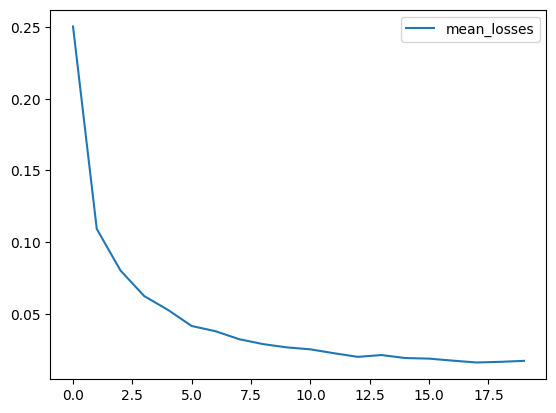

In [34]:
# train
model = ANN(input_dims=784, H1=100, H2=80, n_out=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
mean_losses = []
for epoch in range(20):
    batch_loss = []
    for i, (X,y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted = model(X)
        loss = F.cross_entropy(predicted, y)
        batch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    mean_losses.append(np.mean(batch_loss))  

        
sns.lineplot(data=pd.DataFrame(mean_losses, columns=["mean_losses"]))
plt.show()
plt.close()        

In [59]:
# test
accuracy = 0
tot_count = 0
for i, (X,y) in enumerate(test_dataloader):
    optimizer.zero_grad()
    predicted = model(X)
    y_hat = torch.argmax(predicted, dim=-1)
    target = torch.argmax(y, dim=-1)
    tot_count += X.shape[0]
    accuracy += torch.sum(y_hat == target).item()
print(f"model accuracy: {round((accuracy/tot_count)*100, 2)}%")


model accuracy: 97.34%


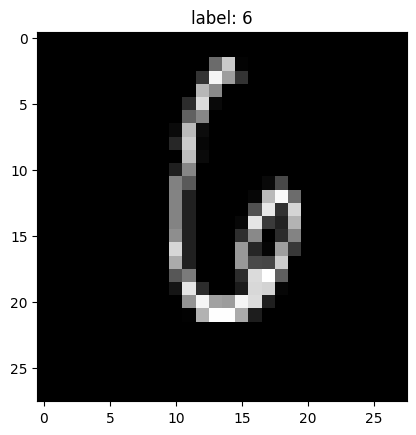

predicted: 6


In [84]:
idx = display_img(test_imgs,test_lbls)
im = torch.tensor(normalize_images(test_imgs[idx]))
im = torch.flatten(im, start_dim=0)
pred = torch.argmax(model(im))
print(f"predicted: {pred}")